# Loading the data
Source: [Brain Tumor Dataset](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection)

In [2]:
from google.colab import files
import json

In [3]:
with open("kaggle.json", "w") as f:
    json.dump(kaggle_api, f)

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection
!unzip brain-mri-images-for-brain-tumor-detection.zip

# Libraries

In [101]:
import os
from tqdm import tqdm

from skimage import filters, exposure
from skimage.filters import gabor
from scipy.ndimage import gaussian_laplace
from PIL import Image
import cv2
import imutils

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import (Dataset,
                              ConcatDataset,
                              DataLoader)
from torchvision import transforms
import timm

# Creating datasets and dataloaders

In [2]:
neg_samples_root = r"/content/no"
pos_samples_root = r"/content/yes"

pos_samples_file_paths = [os.path.join(pos_samples_root, file_name) for file_name in os.listdir(pos_samples_root)]
neg_samples_file_paths = [os.path.join(neg_samples_root, file_name) for file_name in os.listdir(neg_samples_root)]


Detecting cranium and cropping an image

In [162]:
def crop_img(img, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them

    Source: https://www.kaggle.com/code/ruslankl/brain-tumor-detection-v1-0-cnn-vgg-16
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    thresh = thresh.astype("uint8")

    # find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    ADD_PIXELS = add_pixels_value
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

    return new_img

Creating a PyTorch Dataset

In [176]:
class BrainTumorDataset(Dataset):
    def __init__(self, pos_paths, neg_paths, transform=None, apply_edges=False):
        self.files = pos_paths + neg_paths
        self.labels = [1]*len(pos_paths) + [0]*len(neg_paths)
        self.transform = transform or transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])
        self.apply_edges = apply_edges

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        image = cv2.imread(self.files[idx])
        image = crop_img(np.array(image))

        if self.apply_edges:
            edges = filters.sobel(image)  # [H, W] in float32
            image = Image.fromarray((edges * 255).astype(np.uint8))
        else:
            image = Image.fromarray(image.astype(np.uint8))

        image = self.transform(image)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return image, label


Splitting the data

In [183]:
pos_trainval, pos_test = train_test_split(pos_samples_file_paths,
                                          test_size=0.2,
                                          random_state=42)

neg_trainval, neg_test = train_test_split(neg_samples_file_paths,
                                          test_size=0.2,
                                          random_state=42)

pos_train, pos_val = train_test_split(pos_trainval,
                                      test_size=0.25,
                                      random_state=42)

neg_train, neg_val = train_test_split(neg_trainval,
                                      test_size=0.25,
                                      random_state=42)

Data Augmentation to increase the training size

In [184]:
# Basic preprocessing: grayscale, resize, tensor
base_transforms = [
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
]

# Normalization (used last)
normalize = transforms.Normalize(mean=[0.5], std=[0.5])

# Augmentations for training
augmentations = [
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
]

# Compose transforms
train_transform = transforms.Compose(base_transforms + augmentations + [normalize])
general_transform = transforms.Compose(base_transforms + [normalize])

# Create datasets
original_train_dataset = BrainTumorDataset(pos_train, neg_train, transform=general_transform)
augmented_train_dataset = BrainTumorDataset(pos_train, neg_train, transform=train_transform)

# Combine original and augmented data
train_dataset = ConcatDataset([original_train_dataset, augmented_train_dataset])

# Validation and test datasets
val_dataset = BrainTumorDataset(pos_val, neg_val, transform=general_transform)
test_dataset = BrainTumorDataset(pos_test, neg_test, transform=general_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Architecture

Transfer-learning using visual transformer

In [185]:
class ViTMRIClassifier(nn.Module):
    def __init__(self, model_name='vit_base_patch16_224', pretrained=True):
        super(ViTMRIClassifier, self).__init__()
        self.vit = timm.create_model(model_name, pretrained=pretrained)

        # Adapt input layer for 1-channel grayscale
        self.vit.patch_embed.proj = nn.Conv2d(
            in_channels=1,
            out_channels=self.vit.patch_embed.proj.out_channels,
            kernel_size=self.vit.patch_embed.proj.kernel_size,
            stride=self.vit.patch_embed.proj.stride,
            padding=self.vit.patch_embed.proj.padding,
            bias=False
        )

        # Adapt final classification head
        self.vit.head = nn.Linear(self.vit.head.in_features, 1)  # binary classification

    def forward(self, x):
        return self.vit(x)

# Modelling

In [186]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Adding class weights to counter imbalance

In [187]:
# Example: suppose you know these counts
num_pos = len(pos_train) + len(pos_val)
num_neg = len(neg_train) + len(neg_val)

# Compute positive class weight = num_neg / num_pos
pos_weight = torch.tensor([num_neg / num_pos], dtype=torch.float32).to(device)

In [188]:
model = ViTMRIClassifier()
model = model.to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

Training the model

In [189]:
def train_model(model,
                criterion,
                optimizer,
                train_loader,
                test_loader,
                epochs=10,
                lr=1e-4,
                device='cpu'):
    model = model.to(device)

    best_loss = float('inf')
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]"):
            images, labels = images.to(device), labels.float().to(device)

            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * images.size(0)

        avg_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # Evaluation
        model.eval()
        running_test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{epochs} [Testing]"):
                images, labels = images.to(device), labels.float().to(device)
                outputs = model(images).squeeze()
                loss = criterion(outputs, labels)
                running_test_loss += loss.item() * images.size(0)

                preds = (torch.sigmoid(outputs) > 0.5).long()
                correct += (preds == labels.long()).sum().item()
                total += labels.size(0)

        avg_test_loss = running_test_loss / len(test_loader.dataset)
        test_losses.append(avg_test_loss)
        test_accuracy = correct / total * 100

        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f} | Val Loss = {avg_test_loss:.4f} | Val Accuracy = {test_accuracy:.2f}%")

        # Save best model
        if avg_test_loss < best_loss:
            best_loss = avg_test_loss
            torch.save(model.state_dict(), "best_brain_tumor_model.pth")
            print("✅ Best model saved.")

    return train_losses, test_losses


In [190]:
train_losses, test_losses = train_model(model,
                                        criterion,
                                        optimizer,
                                        train_loader,
                                        val_loader,
                                        epochs=50,
                                        lr=1e-4,
                                        device=device)

Epoch 1/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.71it/s]


Epoch 1: Train Loss = 0.7358 | Val Loss = 0.4598 | Val Accuracy = 68.63%
✅ Best model saved.


Epoch 2/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]


Epoch 2: Train Loss = 0.4828 | Val Loss = 0.4702 | Val Accuracy = 68.63%


Epoch 3/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.75it/s]


Epoch 3: Train Loss = 0.4314 | Val Loss = 0.6205 | Val Accuracy = 62.75%


Epoch 4/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.76it/s]


Epoch 4: Train Loss = 0.4990 | Val Loss = 0.4334 | Val Accuracy = 70.59%
✅ Best model saved.


Epoch 5/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]


Epoch 5: Train Loss = 0.4195 | Val Loss = 0.5084 | Val Accuracy = 60.78%


Epoch 6/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]


Epoch 6: Train Loss = 0.3899 | Val Loss = 0.3981 | Val Accuracy = 68.63%
✅ Best model saved.


Epoch 7/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]


Epoch 7: Train Loss = 0.3083 | Val Loss = 0.3389 | Val Accuracy = 84.31%
✅ Best model saved.


Epoch 8/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]


Epoch 8: Train Loss = 0.3081 | Val Loss = 0.3500 | Val Accuracy = 76.47%


Epoch 9/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]


Epoch 9: Train Loss = 0.2435 | Val Loss = 0.5881 | Val Accuracy = 78.43%


Epoch 10/50 [Testing]: 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]


Epoch 10: Train Loss = 0.4230 | Val Loss = 0.3900 | Val Accuracy = 78.43%


Epoch 11/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.75it/s]


Epoch 11: Train Loss = 0.2943 | Val Loss = 0.4711 | Val Accuracy = 74.51%


Epoch 12/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]


Epoch 12: Train Loss = 0.3607 | Val Loss = 0.3905 | Val Accuracy = 78.43%


Epoch 13/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]


Epoch 13: Train Loss = 0.3407 | Val Loss = 0.4234 | Val Accuracy = 74.51%


Epoch 14/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]


Epoch 14: Train Loss = 0.2476 | Val Loss = 0.3276 | Val Accuracy = 80.39%
✅ Best model saved.


Epoch 15/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


Epoch 15: Train Loss = 0.2127 | Val Loss = 0.6112 | Val Accuracy = 72.55%


Epoch 16/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.41it/s]


Epoch 16: Train Loss = 0.3925 | Val Loss = 0.4498 | Val Accuracy = 74.51%


Epoch 17/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.52it/s]


Epoch 17: Train Loss = 0.2798 | Val Loss = 0.4746 | Val Accuracy = 76.47%


Epoch 18/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.57it/s]


Epoch 18: Train Loss = 0.1570 | Val Loss = 0.4659 | Val Accuracy = 84.31%


Epoch 19/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]


Epoch 19: Train Loss = 0.1157 | Val Loss = 0.4670 | Val Accuracy = 80.39%


Epoch 20/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]


Epoch 20: Train Loss = 0.0956 | Val Loss = 0.4478 | Val Accuracy = 84.31%


Epoch 21/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]


Epoch 21: Train Loss = 0.1449 | Val Loss = 0.5138 | Val Accuracy = 78.43%


Epoch 22/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.77it/s]


Epoch 22: Train Loss = 0.1253 | Val Loss = 0.3541 | Val Accuracy = 84.31%


Epoch 23/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]


Epoch 23: Train Loss = 0.0726 | Val Loss = 0.4458 | Val Accuracy = 82.35%


Epoch 24/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]


Epoch 24: Train Loss = 0.0794 | Val Loss = 0.4797 | Val Accuracy = 86.27%


Epoch 25/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.77it/s]


Epoch 25: Train Loss = 0.0362 | Val Loss = 0.6743 | Val Accuracy = 84.31%


Epoch 26/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]


Epoch 26: Train Loss = 0.0651 | Val Loss = 0.5429 | Val Accuracy = 84.31%


Epoch 27/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]


Epoch 27: Train Loss = 0.0640 | Val Loss = 0.4885 | Val Accuracy = 82.35%


Epoch 28/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]


Epoch 28: Train Loss = 0.0898 | Val Loss = 0.4389 | Val Accuracy = 84.31%


Epoch 29/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.77it/s]


Epoch 29: Train Loss = 0.0610 | Val Loss = 0.3974 | Val Accuracy = 88.24%


Epoch 30/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]


Epoch 30: Train Loss = 0.0660 | Val Loss = 0.5132 | Val Accuracy = 82.35%


Epoch 31/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]


Epoch 31: Train Loss = 0.0476 | Val Loss = 0.5782 | Val Accuracy = 78.43%


Epoch 32/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]


Epoch 32: Train Loss = 0.0383 | Val Loss = 0.5645 | Val Accuracy = 86.27%


Epoch 33/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]


Epoch 33: Train Loss = 0.0463 | Val Loss = 0.7967 | Val Accuracy = 76.47%


Epoch 34/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.75it/s]


Epoch 34: Train Loss = 0.0277 | Val Loss = 0.8259 | Val Accuracy = 80.39%


Epoch 35/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]


Epoch 35: Train Loss = 0.0227 | Val Loss = 0.6717 | Val Accuracy = 82.35%


Epoch 36/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]


Epoch 36: Train Loss = 0.0227 | Val Loss = 0.7957 | Val Accuracy = 78.43%


Epoch 37/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]


Epoch 37: Train Loss = 0.0883 | Val Loss = 0.4178 | Val Accuracy = 84.31%


Epoch 38/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]


Epoch 38: Train Loss = 0.0699 | Val Loss = 0.5489 | Val Accuracy = 78.43%


Epoch 39/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.77it/s]


Epoch 39: Train Loss = 0.0449 | Val Loss = 0.6130 | Val Accuracy = 86.27%


Epoch 40/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]


Epoch 40: Train Loss = 0.0379 | Val Loss = 0.6531 | Val Accuracy = 78.43%


Epoch 41/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]


Epoch 41: Train Loss = 0.0353 | Val Loss = 0.5929 | Val Accuracy = 82.35%


Epoch 42/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]


Epoch 42: Train Loss = 0.0600 | Val Loss = 0.5586 | Val Accuracy = 80.39%


Epoch 43/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]


Epoch 43: Train Loss = 0.0303 | Val Loss = 0.5035 | Val Accuracy = 84.31%


Epoch 44/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]


Epoch 44: Train Loss = 0.0346 | Val Loss = 0.5051 | Val Accuracy = 88.24%


Epoch 45/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]


Epoch 45: Train Loss = 0.0310 | Val Loss = 0.4530 | Val Accuracy = 88.24%


Epoch 46/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]


Epoch 46: Train Loss = 0.0212 | Val Loss = 0.5574 | Val Accuracy = 88.24%


Epoch 47/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.75it/s]


Epoch 47: Train Loss = 0.0174 | Val Loss = 0.8121 | Val Accuracy = 82.35%


Epoch 48/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]


Epoch 48: Train Loss = 0.0063 | Val Loss = 0.8292 | Val Accuracy = 82.35%


Epoch 49/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]


Epoch 49: Train Loss = 0.0172 | Val Loss = 0.9210 | Val Accuracy = 82.35%


Epoch 50/50 [Testing]: 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

Epoch 50: Train Loss = 0.0535 | Val Loss = 0.6278 | Val Accuracy = 80.39%


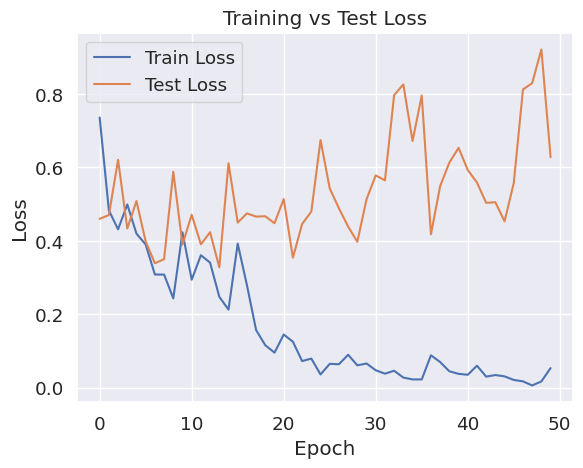

In [191]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Test Loss')
plt.legend()
plt.show()

# Evaluation

In [192]:
device = "cuda"
model = ViTMRIClassifier()
model.load_state_dict(torch.load("best_brain_tumor_model.pth"))
model.eval()
model = model.to(device)

Some explainability

In [193]:
class AttentionRollout:
    def __init__(self, model, discard_ratio=0.9, head_fusion='mean'):
        self.model = model
        self.discard_ratio = discard_ratio
        self.head_fusion = head_fusion
        self.attentions = []

        # Hook attention layers
        for blk in self.model.vit.blocks:
            blk.attn.register_forward_hook(self._hook)

    def _hook(self, module, input, output):
        qkv = module.qkv(input[0])  # Shape: [B, N, 3*dim]
        B, N, _ = qkv.shape
        qkv = qkv.reshape(B, N, 3, module.num_heads, -1 // module.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # Each: [B, heads, tokens, dim_head]

        attn = (q @ k.transpose(-2, -1)) * module.scale
        attn = attn.softmax(dim=-1)
        self.attentions.append(attn.detach().cpu())

    def compute_rollout_attention(self):
        result = torch.eye(self.attentions[0].size(-1))
        for attention in self.attentions:
            if self.head_fusion == 'mean':
                attn = attention.mean(dim=1)
            elif self.head_fusion == 'max':
                attn = attention.max(dim=1)[0]
            elif self.head_fusion == 'min':
                attn = attention.min(dim=1)[0]

            # Discard low attention
            flat = attn.view(attn.size(0), -1)
            _, indices = flat.topk(int(flat.size(-1) * self.discard_ratio), dim=-1, largest=False)
            flat.scatter_(1, indices, 0)
            attn = flat.view_as(attn)

            attn = attn / attn.sum(dim=-1, keepdim=True)
            result = torch.matmul(attn, result)

        mask = result[0, 0, 1:]  # skip CLS token
        num_patches = int(mask.shape[0]**0.5)
        mask = mask.reshape(num_patches, num_patches).numpy()
        mask = (mask - mask.min()) / (mask.max() - mask.min())
        self.attentions.clear()
        return mask


Attention Rollout plot

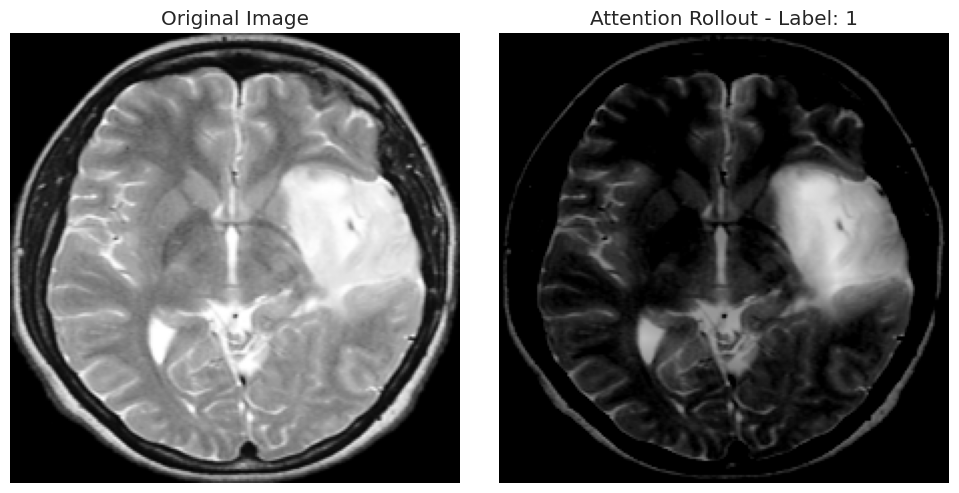

In [194]:
img_tensor, label = test_dataset[3]
input_tensor = img_tensor.unsqueeze(0).to(device)

rollout = AttentionRollout(model, discard_ratio=0.9)
_ = model(input_tensor)

mask = rollout.compute_rollout_attention()

# Resize and overlay
mask_resized = torch.tensor(mask).unsqueeze(0).unsqueeze(0)
mask_resized = F.interpolate(mask_resized, size=(224, 224), mode='bilinear', align_corners=False)
mask_resized = mask_resized.squeeze().cpu().numpy()

img_np = img_tensor.squeeze().cpu().numpy()
img_rgb = np.stack([img_np]*3, axis=-1)

# Create heatmap overlay
heatmap = (mask_resized - mask_resized.min()) / (mask_resized.max() - mask_resized.min())
overlay = img_rgb * 0.5 + np.stack([heatmap]*3, axis=-1) * 0.5
overlay = np.clip(overlay, 0, 1)

# Plot
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_np, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title(f"Attention Rollout - Label: {int(label.item())}")
plt.axis('off')

plt.tight_layout()
plt.show()

Classification Report

In [195]:
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images).squeeze()
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).long()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy().astype(int))


In [196]:
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['No Tumor', 'Tumor']))

Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.95      0.90      0.92        20
       Tumor       0.94      0.97      0.95        31

    accuracy                           0.94        51
   macro avg       0.94      0.93      0.94        51
weighted avg       0.94      0.94      0.94        51



Confusion Matrix

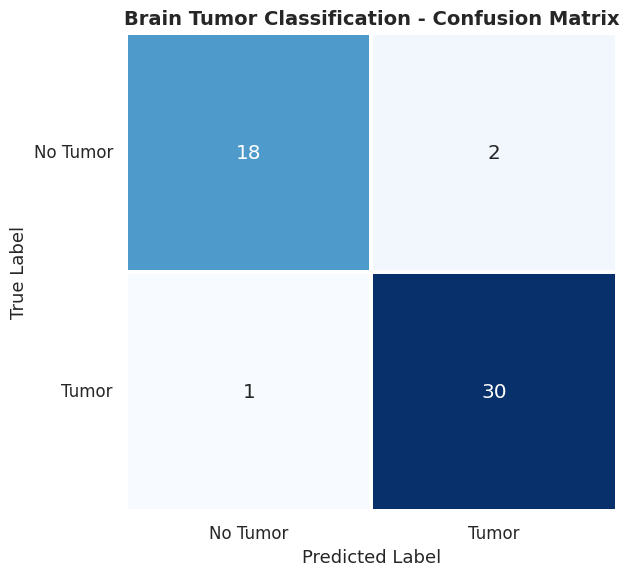

In [197]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6.5, 6))
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                 cbar=False, linewidths=1.5, linecolor='white',
                 xticklabels=['No Tumor', 'Tumor'],
                 yticklabels=['No Tumor', 'Tumor'])

ax.set_xlabel("Predicted Label", fontsize=13)
ax.set_ylabel("True Label", fontsize=13)
ax.set_title("Brain Tumor Classification - Confusion Matrix", fontsize=14, weight='bold')

ax.tick_params(axis='both', which='major', labelsize=12)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Plotting the rollout of incorrectly predicted images

In [198]:
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

wrong_indices = np.where(all_preds != all_labels)[0]
wrong_samples = [test_dataset[i] for i in wrong_indices]

print(f"Found {len(wrong_indices)} wrong predictions.")

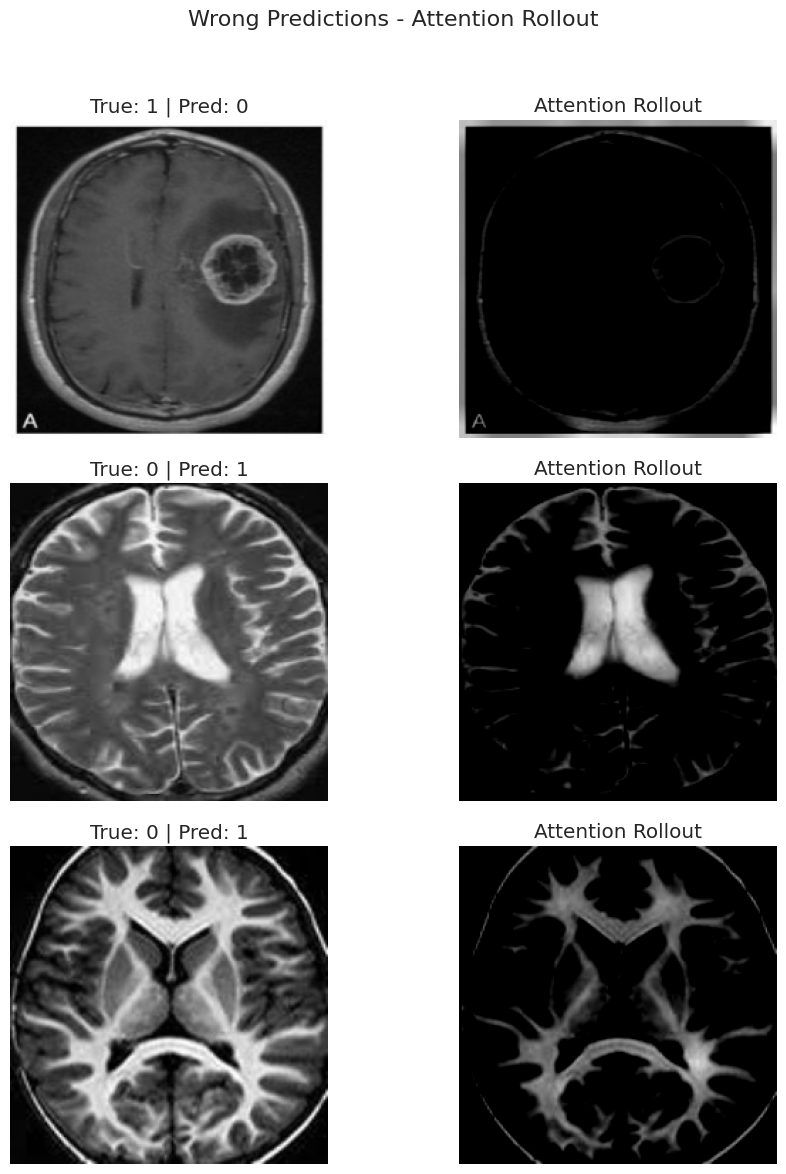

In [205]:
fig, axes = plt.subplots(nrows=len(wrong_indices), ncols=2, figsize=(10, 12))
fig.suptitle("Wrong Predictions - Attention Rollout", fontsize=16)

for i, idx in enumerate(wrong_indices):
    img_tensor, label = test_dataset[idx]
    input_tensor = img_tensor.unsqueeze(0).to(device)

    # Run forward pass and attention rollout
    rollout = AttentionRollout(model, discard_ratio=0.9)
    _ = model(input_tensor)

    # Compute attention map
    mask = rollout.compute_rollout_attention()
    mask_resized = torch.tensor(mask).unsqueeze(0).unsqueeze(0)
    mask_resized = F.interpolate(mask_resized, size=(224, 224), mode='bilinear', align_corners=False)
    mask_resized = mask_resized.squeeze().cpu().numpy()

    # Prepare image
    img_np = img_tensor.squeeze().cpu().numpy()
    img_rgb = np.stack([img_np]*3, axis=-1)  # convert to RGB

    # Heatmap overlay
    heatmap = (mask_resized - mask_resized.min()) / (mask_resized.max() - mask_resized.min() + 1e-8)
    overlay = img_rgb * 0.5 + np.stack([heatmap]*3, axis=-1) * 0.5
    overlay = np.clip(overlay, 0, 1)

    # Plot original
    axes[i, 0].imshow(img_np, cmap='gray')
    axes[i, 0].set_title(f"True: {int(label)} | Pred: {int(all_preds[idx])}")
    axes[i, 0].axis('off')

    # Plot overlay
    axes[i, 1].imshow(overlay)
    axes[i, 1].set_title("Attention Rollout")
    axes[i, 1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle
plt.show()